In [1]:
cd ..

C:\Users\macle\Dropbox\mcode\DCGAN


In [2]:
import torch
import torch.nn.functional as F
from model import Generator, Discriminator, DCGAN
from utils import create_dataset, init_params, inspect_tensor
from torchvision.utils import make_grid, save_image
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
from skimage.io import imread

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def show_image_grid(tensor, figsize=(10, 5), **kwargs):
    _, ax = plt.subplots(figsize=figsize)
    ax.imshow(make_grid(tensor, **kwargs).data.numpy().transpose([1,2,0]))

In [4]:
def plot_hist(sample):
    plt.hist(sample.data.numpy().flatten(), bins=25)
    plt.show();

In [5]:
def check_sample(sample):
    plt.hist(sample.data.numpy().flatten(), bins=25)
    plt.show();
    show_image_grid(sample, figsize=(15,10));

In [26]:
image_ch = 3
image_dim = 150
z_size = 100

image_dataset = create_dataset(root_dir='images')

discriminator = Discriminator(input_dim=image_dim, input_ch=image_ch)
generator = Generator(input_size=z_size, output_dim=image_dim, output_ch=image_ch)


z_sample = generator.z_sample(batch_size=64)
z_sample = torch.randn(64, 100)

dcgan = DCGAN(discriminator, generator)

In [7]:
image_dataset[0][0].shape

torch.Size([3, 150, 150])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


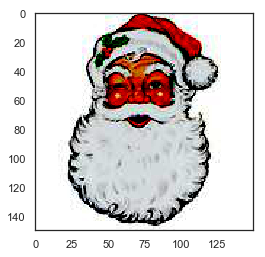

In [8]:
plt.imshow(image_dataset[0][0].numpy().transpose(1,2,0))

In [9]:
dataloader = DataLoader(image_dataset, batch_size=32, shuffle=True)

In [10]:
batch = next(iter(dataloader))[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


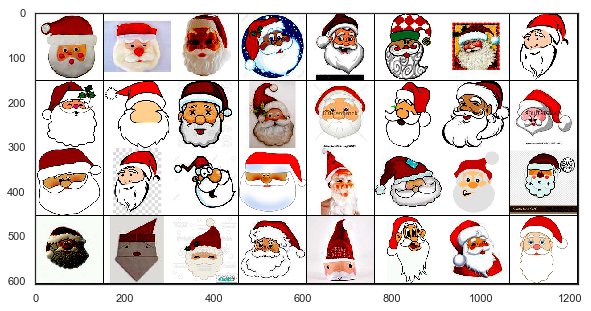

In [11]:
show_image_grid(batch)

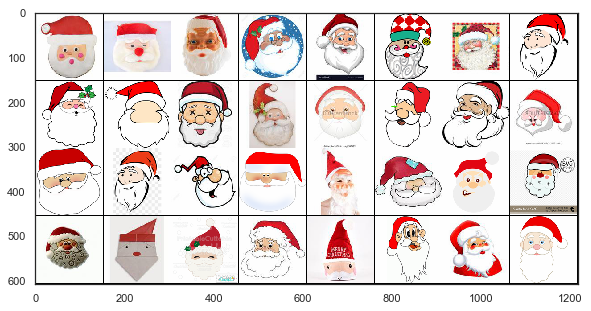

In [12]:
show_image_grid(batch, normalize=True) # Normalize between 0-1

In [37]:
# load trained model
model = torch.load('train/checkpoint_846.pt')
model.generator.eval()
model.discriminator.eval()

Discriminator(
  (conv_block): Sequential(
    (0): StandardConv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): StandardConv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): StandardConv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): StandardConv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
  )
  (linear): Linear(in_features=51200, out_features=1, bias=True)
)

In [38]:
gen_sample = model.generator(z_sample).data

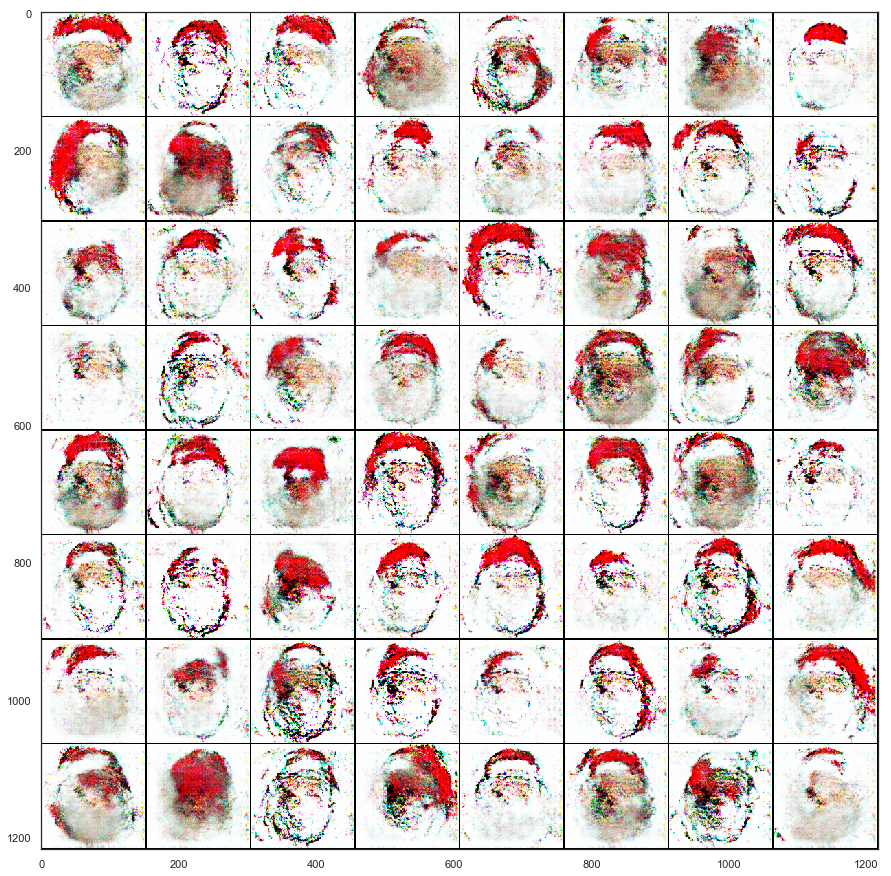

In [40]:
show_image_grid(gen_sample, figsize=(15,20), normalize=True)

In [16]:
gen_sample.shape

torch.Size([16, 3, 150, 150])

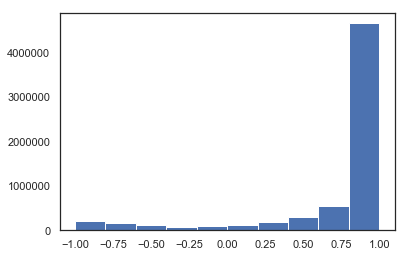

In [17]:
_ = plt.hist(np.hstack(image[0] for image in image_dataset).flatten())

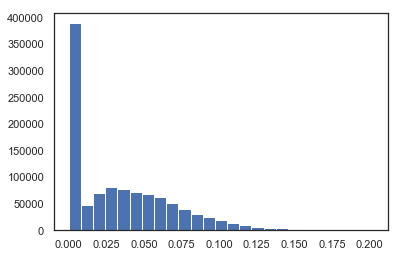

In [18]:
_ = plt.hist(gen_sample.flatten().numpy(), bins=25)

In [19]:
gen_sample_raw = dcgan.generator(z_sample).data

In [20]:
gen_sample_raw.shape

torch.Size([16, 3, 150, 150])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


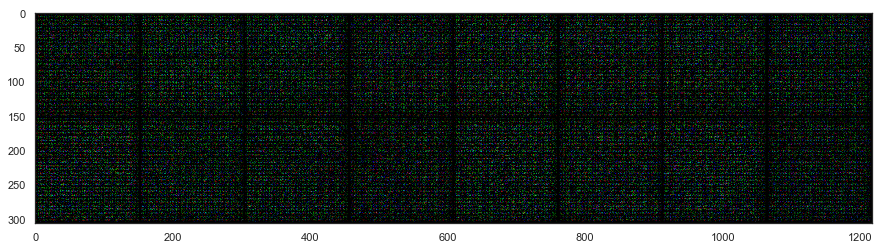

In [21]:
show_image_grid(gen_sample_raw, figsize=(15,10))

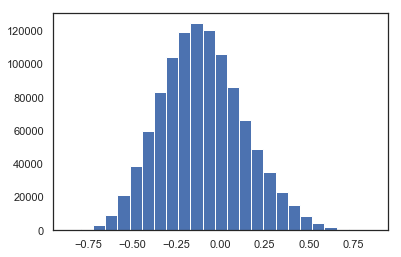

In [22]:
_ = plt.hist(gen_sample_raw.flatten().numpy(), bins=25)

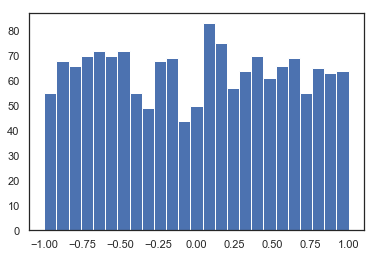

In [23]:
_ = plt.hist(z_sample.numpy().flatten(), bins=25)

In [24]:
linear = generator.linear(z_sample)

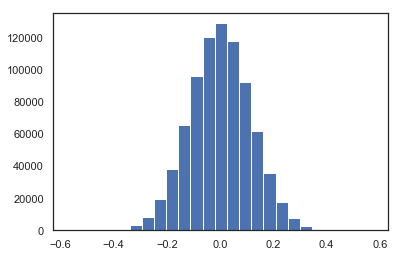

In [25]:
_ = plt.hist(linear.data.numpy().flatten(), bins=25)

In [26]:
linear.shape

torch.Size([16, 51200])

In [27]:
self = generator

In [28]:
reshape = linear.reshape(linear.shape[0], self.deconv0_in_ch, self.deconv0_in_dim, self.deconv0_in_dim)

In [29]:
reshape.shape

torch.Size([16, 512, 10, 10])

In [30]:
generator.deconv_block[:2]

Sequential(
  (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
)

In [31]:
relu_a = generator.deconv_block[:2](reshape)

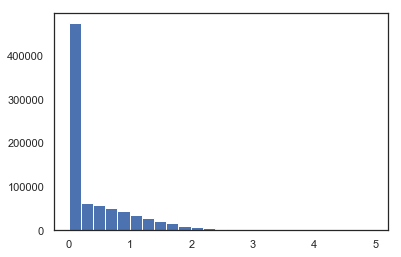

In [32]:
_ = plt.hist(relu_a.data.numpy().flatten(), bins=25)

In [33]:
relu_a.shape

torch.Size([16, 512, 10, 10])

In [34]:
generator.deconv_block[2:5]

Sequential(
  (2): StandardConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
)

In [35]:
relu_1_a = generator.deconv_block[2:5](relu_a)

relu_1_a.shape

torch.Size([16, 256, 19, 19])

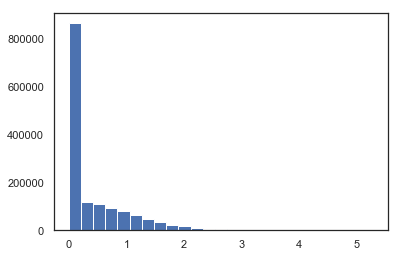

In [36]:
_ = plt.hist(relu_1_a.data.numpy().flatten(), bins=25)

In [37]:
generator.deconv_block[5:8]

Sequential(
  (5): StandardConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
)

In [38]:
relu_2_a = generator.deconv_block[5:8](relu_1_a)

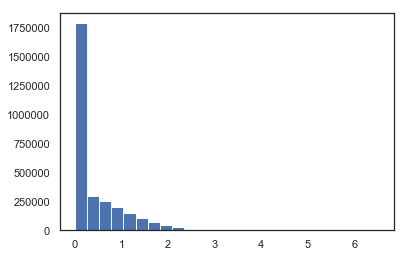

In [39]:
_ = plt.hist(relu_2_a.data.numpy().flatten(), bins=25)

In [40]:
generator.deconv_block[8:11]

Sequential(
  (8): StandardConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
)

In [41]:
relu_3_a = generator.deconv_block[8:11](relu_2_a)

relu_3_a.shape

torch.Size([16, 64, 75, 75])

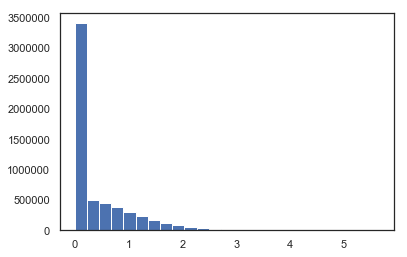

In [42]:
_ = plt.hist(relu_3_a.data.numpy().flatten(), bins=25)

Discriminator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


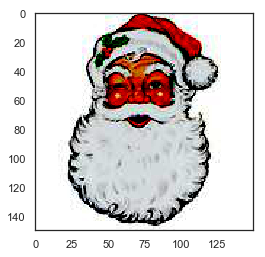

In [43]:
sample_image = image_dataset[0][0]

sample_image_batch =  np.repeat(sample_image[None,...], 16, axis=0)

plt.imshow(sample_image.numpy().transpose(1,2,0))

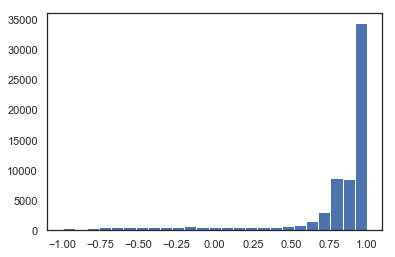

In [44]:
plot_hist(sample_image)

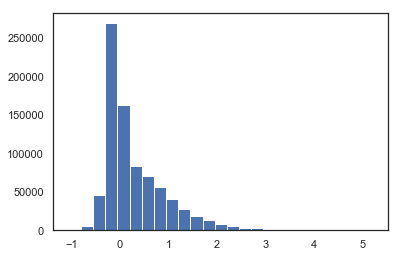

In [45]:
plot_hist(discriminator.conv_block(sample_image_batch).flatten())

In [49]:
6np.m % 6

0

In [50]:
np.mod(1, 6)

1